In [1]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

EPISODES = 300


# DQN Agent for the Cartpole
# it uses Neural Network to approximate q function
# and replay memory & target q network
class DQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model
        self.update_target_model()

        if self.load_model:
            self.model.load_weights("./save_model/cartpole_dqn.h5")

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        # and do the model fit!
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)

Using TensorFlow backend.


In [2]:
# In case of CartPole-v1, maximum length of episode is 500
env = gym.make('CartPole-v1')
# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)

scores, episodes = [], []

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:
        if agent.render:
            env.render()

        # get action for the current state and go one step in environment
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
        reward = reward if not done or score == 499 else -100

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        # every time step do the training
        agent.train_model()
        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()

            # every episode, plot the play time
            score = score if score == 500 else score + 100
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            #pylab.savefig("./save_graph/cartpole_dqn.png")
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

            # if the mean of scores of last 10 episode is bigger than 490
            # stop training
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                sys.exit()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
__________________________________

episode: 87   score: 299.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 88   score: 500.0   memory length: 2000   epsilon: 0.009998671593271896
episode: 89   score: 418.0   memory length: 2000   epsilon: 0.009998671593271896


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\ishtd\Anaconda3\envs\deeplearning\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-1d1ccd616461>", line 31, in <module>
    agent.train_model()
  File "<ipython-input-1-9b8e0d0adf2e>", line 111, in train_model
    epochs=1, verbose=0)
  File "C:\Users\ishtd\Anaconda3\envs\deeplearning\lib\site-packages\keras\engine\training.py", line 1239, in fit
    validation_freq=validation_freq)
  File "C:\Users\ishtd\Anaconda3\envs\deeplearning\lib\site-packages\keras\engine\training_arrays.py", line 196, in fit_loop
    outs = fit_function(ins_batch)
  File "C:\Users\ishtd\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow_core\python\keras\backend.py", line 3740, in __call__
    outputs = self._graph_fn(*converted_inputs)
  File "C:\Users\ishtd\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow_core\python\eager\function.py", li

TypeError: object of type 'NoneType' has no len()

Error in callback <function flush_figures at 0x000001E04B40A2F0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# testing the network
from tqdm import tqdm
for i in tqdm(range(500)):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for j in range(1000):
        env.render()
        nn_out = agent.get_action(state)
        print(nn_out)
        state,reward,done,info = env.step(nn_out)
        state = np.reshape(state, [1, state_size])
        if done:
            print("episode ended")
            break
env.close()

In [11]:
env.close()

## SARSA (WITH NN)

In [30]:
import copy
import pylab
import random
import numpy as np
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

EPISODES = 1000


# this is DeepSARSA Agent for the GridWorld
# Utilize Neural Network as q function approximator
class DeepSARSAgent:
    def __init__(self):
        self.load_model = False
        # actions which agent can do
        self.action_space = [0, 1]
        # get size of state and action
        self.action_size = len(self.action_space)
        self.state_size = 4
        self.discount_factor = 0.99
        self.learning_rate = 0.001

        self.epsilon = 1.  # exploration
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.model = self.build_model()

        
    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(30, input_dim=self.state_size, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            # The agent acts randomly
            return random.randrange(self.action_size)
        else:
            # Predict the reward value based on the given state
            state = np.float32(state)
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        state = np.float32(state)
        next_state = np.float32(next_state)
        target = self.model.predict(state)[0]

        
        # like Q Learning, get maximum Q value at s'
        # But from target model
        if done:
            target[action] = reward
        else:
            target[action] = (reward + self.discount_factor *
                              self.model.predict(next_state)[0][next_action])

        target = np.reshape(target, [1, 2])

        # make minibatch which includes target q value and predicted q value
        # and do the model fit!
        self.model.fit(state, target, epochs=1,verbose = 0)



Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 30)                150       
_________________________________________________________________
dense_41 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 62        
Total params: 1,142
Trainable params: 1,142
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: 13.0 global_step 13   epsilon: 0.9987007797140718
episode: 1   score: 22.0 global_step 35   epsilon: 0.9965059434602331
episode: 2   score: 20.0 global_step 55   epsilon: 0.9945148237990713
episode: 3   score: 14.0 global_step 69   epsilon: 0.9931234076923388
episode: 4   score: 20.0 global_step 89   epsilon: 0.9911390466797494
episode: 5   score: 14.0 global

episode: 103   score: 35.0 global_step 2169   epsilon: 0.8050017354535077
episode: 104   score: 19.0 global_step 2188   epsilon: 0.803473607929379
episode: 105   score: 13.0 global_step 2201   epsilon: 0.802429718718749
episode: 106   score: 20.0 global_step 2221   epsilon: 0.800826382983396
episode: 107   score: 22.0 global_step 2243   epsilon: 0.7990664136170905
episode: 108   score: 18.0 global_step 2261   epsilon: 0.797629315992399
episode: 109   score: 10.0 global_step 2271   epsilon: 0.7968320455139001
episode: 110   score: 12.0 global_step 2283   epsilon: 0.7958763727931698
episode: 111   score: 15.0 global_step 2298   epsilon: 0.7946833935421564
episode: 112   score: 21.0 global_step 2319   epsilon: 0.793016226194391
episode: 113   score: 30.0 global_step 2349   epsilon: 0.7906406239189183
episode: 114   score: 15.0 global_step 2364   epsilon: 0.7894554927960618
episode: 115   score: 31.0 global_step 2395   epsilon: 0.787011848190316
episode: 116   score: 63.0 global_step 2458 

episode: 215   score: 14.0 global_step 4764   epsilon: 0.6210002331610694
episode: 216   score: 28.0 global_step 4792   epsilon: 0.6192637778559741
episode: 217   score: 43.0 global_step 4835   epsilon: 0.6166065279284098
episode: 218   score: 31.0 global_step 4866   epsilon: 0.6146979121424796
episode: 219   score: 15.0 global_step 4881   epsilon: 0.6137765104274701
episode: 220   score: 24.0 global_step 4905   epsilon: 0.6123051395839814
episode: 221   score: 17.0 global_step 4922   epsilon: 0.6112650531654568
episode: 222   score: 13.0 global_step 4935   epsilon: 0.6104708852083052
episode: 223   score: 65.0 global_step 5000   epsilon: 0.6065154956247766
episode: 224   score: 30.0 global_step 5030   epsilon: 0.6046985850195162
episode: 225   score: 56.0 global_step 5086   epsilon: 0.6013215685615586
episode: 226   score: 16.0 global_step 5102   epsilon: 0.600360175301112
episode: 227   score: 21.0 global_step 5123   epsilon: 0.599100678891228
episode: 228   score: 24.0 global_step 5

episode: 326   score: 63.0 global_step 8429   epsilon: 0.4304422339205948
episode: 327   score: 73.0 global_step 8502   epsilon: 0.42731129090988323
episode: 328   score: 30.0 global_step 8532   epsilon: 0.4260312141075558
episode: 329   score: 31.0 global_step 8563   epsilon: 0.4247124964752977
episode: 330   score: 70.0 global_step 8633   epsilon: 0.42174974259688924
episode: 331   score: 44.0 global_step 8677   epsilon: 0.4198980279020955
episode: 332   score: 38.0 global_step 8715   epsilon: 0.41830536374004157
episode: 333   score: 43.0 global_step 8758   epsilon: 0.41651042281624584
episode: 334   score: 21.0 global_step 8779   epsilon: 0.4156366250465101
episode: 335   score: 20.0 global_step 8799   epsilon: 0.4148061410323803
episode: 336   score: 17.0 global_step 8816   epsilon: 0.41410153444700754
episode: 337   score: 22.0 global_step 8838   epsilon: 0.4131914670083552
episode: 338   score: 11.0 global_step 8849   epsilon: 0.4127371835817899
episode: 339   score: 18.0 global

episode: 436   score: 59.0 global_step 14052   epsilon: 0.24530075136326532
episode: 437   score: 223.0 global_step 14275   epsilon: 0.23989081905345078
episode: 438   score: 30.0 global_step 14305   epsilon: 0.23917218914805372
episode: 439   score: 60.0 global_step 14365   epsilon: 0.23774138118809096
episode: 440   score: 145.0 global_step 14510   epsilon: 0.2343188334702565
episode: 441   score: 328.0 global_step 14838   epsilon: 0.22675748174890267
episode: 442   score: 34.0 global_step 14872   epsilon: 0.22598777706456336
episode: 443   score: 18.0 global_step 14890   epsilon: 0.22558134464280916
episode: 444   score: 28.0 global_step 14918   epsilon: 0.2249505688367493
episode: 445   score: 136.0 global_step 15054   epsilon: 0.22191179962994384
episode: 446   score: 223.0 global_step 15277   epsilon: 0.2170176938920887
episode: 447   score: 32.0 global_step 15309   epsilon: 0.21632431260376803
episode: 448   score: 129.0 global_step 15438   epsilon: 0.21355151333778116
episode: 

episode: 544   score: 20.0 global_step 24255   epsilon: 0.08842316615572028
episode: 545   score: 18.0 global_step 24273   epsilon: 0.08826413967195798
episode: 546   score: 21.0 global_step 24294   epsilon: 0.08807897021600171
episode: 547   score: 18.0 global_step 24312   epsilon: 0.08792056275859188
episode: 548   score: 21.0 global_step 24333   epsilon: 0.0877361140930989
episode: 549   score: 34.0 global_step 24367   epsilon: 0.08743830298017621
episode: 550   score: 30.0 global_step 24397   epsilon: 0.08717636807309365
episode: 551   score: 111.0 global_step 24508   epsilon: 0.08621401321982554
episode: 552   score: 194.0 global_step 24702   epsilon: 0.08455749868334705
episode: 553   score: 170.0 global_step 24872   epsilon: 0.08313210015203104
episode: 554   score: 189.0 global_step 25061   epsilon: 0.0815755810729269
episode: 555   score: 257.0 global_step 25318   epsilon: 0.0795056970852523
episode: 556   score: 128.0 global_step 25446   epsilon: 0.07849445932889014
episode: 

episode: 651   score: 500.0 global_step 41799   epsilon: 0.015296839983622272
episode: 652   score: 500.0 global_step 42299   epsilon: 0.01455076791491002
episode: 653   score: 500.0 global_step 42799   epsilon: 0.013841083984683157
episode: 654   score: 500.0 global_step 43299   epsilon: 0.013166013435947055
episode: 655   score: 500.0 global_step 43799   epsilon: 0.01252386807184786
episode: 656   score: 500.0 global_step 44299   epsilon: 0.0119130420338788
episode: 657   score: 169.0 global_step 44468   epsilon: 0.011713393423683808
episode: 658   score: 204.0 global_step 44672   epsilon: 0.011476849323958434
episode: 659   score: 147.0 global_step 44819   epsilon: 0.011309365288325523
episode: 660   score: 13.0 global_step 44832   epsilon: 0.011294671931521958
episode: 661   score: 17.0 global_step 44849   epsilon: 0.011275486342314508
episode: 662   score: 500.0 global_step 45349   epsilon: 0.010725547568675385
episode: 663   score: 22.0 global_step 45371   epsilon: 0.010701976123

episode: 757   score: 133.0 global_step 60534   epsilon: 0.009999399224421553
episode: 758   score: 114.0 global_step 60648   epsilon: 0.009999399224421553
episode: 759   score: 131.0 global_step 60779   epsilon: 0.009999399224421553
episode: 760   score: 131.0 global_step 60910   epsilon: 0.009999399224421553
episode: 761   score: 152.0 global_step 61062   epsilon: 0.009999399224421553
episode: 762   score: 146.0 global_step 61208   epsilon: 0.009999399224421553
episode: 763   score: 134.0 global_step 61342   epsilon: 0.009999399224421553
episode: 764   score: 127.0 global_step 61469   epsilon: 0.009999399224421553
episode: 765   score: 125.0 global_step 61594   epsilon: 0.009999399224421553
episode: 766   score: 143.0 global_step 61737   epsilon: 0.009999399224421553
episode: 767   score: 22.0 global_step 61759   epsilon: 0.009999399224421553
episode: 768   score: 159.0 global_step 61918   epsilon: 0.009999399224421553
episode: 769   score: 183.0 global_step 62101   epsilon: 0.009999

episode: 863   score: 161.0 global_step 85169   epsilon: 0.009999399224421553
episode: 864   score: 219.0 global_step 85388   epsilon: 0.009999399224421553
episode: 865   score: 227.0 global_step 85615   epsilon: 0.009999399224421553
episode: 866   score: 259.0 global_step 85874   epsilon: 0.009999399224421553
episode: 867   score: 232.0 global_step 86106   epsilon: 0.009999399224421553
episode: 868   score: 500.0 global_step 86606   epsilon: 0.009999399224421553
episode: 869   score: 187.0 global_step 86793   epsilon: 0.009999399224421553
episode: 870   score: 206.0 global_step 86999   epsilon: 0.009999399224421553
episode: 871   score: 302.0 global_step 87301   epsilon: 0.009999399224421553
episode: 872   score: 234.0 global_step 87535   epsilon: 0.009999399224421553
episode: 873   score: 230.0 global_step 87765   epsilon: 0.009999399224421553
episode: 874   score: 500.0 global_step 88265   epsilon: 0.009999399224421553
episode: 875   score: 445.0 global_step 88710   epsilon: 0.00999

episode: 969   score: 172.0 global_step 102592   epsilon: 0.009999399224421553
episode: 970   score: 183.0 global_step 102775   epsilon: 0.009999399224421553
episode: 971   score: 203.0 global_step 102978   epsilon: 0.009999399224421553
episode: 972   score: 182.0 global_step 103160   epsilon: 0.009999399224421553
episode: 973   score: 320.0 global_step 103480   epsilon: 0.009999399224421553
episode: 974   score: 188.0 global_step 103668   epsilon: 0.009999399224421553
episode: 975   score: 350.0 global_step 104018   epsilon: 0.009999399224421553
episode: 976   score: 202.0 global_step 104220   epsilon: 0.009999399224421553
episode: 977   score: 500.0 global_step 104720   epsilon: 0.009999399224421553
episode: 978   score: 141.0 global_step 104861   epsilon: 0.009999399224421553
episode: 979   score: 11.0 global_step 104872   epsilon: 0.009999399224421553
episode: 980   score: 10.0 global_step 104882   epsilon: 0.009999399224421553
episode: 981   score: 10.0 global_step 104892   epsilo

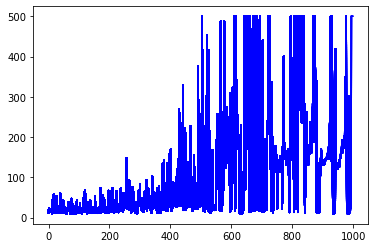

In [31]:
env = gym.make('CartPole-v1')
agent = DeepSARSAgent()

global_step = 0
scores, episodes = [], []

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, 4])

    while not done:
        
        # fresh env
        global_step += 1

        # get action for the current state and go one step in environment
        action = agent.get_action(state)
        next_state, reward, done,info = env.step(action)
        next_state = np.reshape(next_state, [1, 4])
        next_action = agent.get_action(next_state)
        agent.train_model(state, action, reward, next_state, next_action,
                          done)
        state = next_state
        # every time step we do training
        score += reward

        state = copy.deepcopy(next_state)

        if done:
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')

            print("episode:", e, "  score:", score, "global_step",
                  global_step, "  epsilon:", agent.epsilon)


In [32]:
for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, 4])

    while not done:
        # fresh env
        global_step += 1
        env.render()
        # get action for the current state and go one step in environment
        action = agent.get_action(state)
        next_state, reward, done,info = env.step(action)
        next_state = np.reshape(next_state, [1, 4])
        next_action = agent.get_action(next_state)
        
        state = next_state
        # every time step we do training
        score += reward

        state = copy.deepcopy(next_state)



KeyboardInterrupt: 

In [26]:
env.close()